### A Binary Classifier built using a FC network, with PyTorch

We will be working with the Attrition dataset and we want to build a binary classifier: a model enabling to predict if the employee wants to leave the company (target = 1)

Here we explore:
* how to define Network Architecture
* How to write the training loop

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

from attrition_dataset import AttritionDataset

# pyplot to plot the training loss
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# check that access to GPU is OK
torch.cuda.is_available()

True

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# need to make training reproducible
torch.manual_seed(42)

#### Here you find defined the Network architecture

In [4]:
# we need to implement a class subclassing nn.Module, writing the forward method

#non conviene avere una rete troppo profonda e con troppi parametri... i dati non sono tantissimi
class FirstFC(nn.Module):
    # here we define the structure
    def __init__(self):
        super(FirstFC, self).__init__()
        self.fc1 = nn.Linear(30, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, 10)
        self.fc5 = nn.Linear(10, 1)
        # fondamentale memorizzare anche il dropout tra gli attributi 
        # per disattivarlo in modalità eval
        # altrimenti in eval i risultati non sono pienamente riproducibili
        self.drop = nn.Dropout(0.1)
    
    # here we implement the forward pass
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop(x)
        
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        # the last layer must give the prob that it is positive... so we use sigmoid
        # so we must use nn.BCELoss
        x = torch.sigmoid(self.fc5(x))
        
        return x

In [5]:
# dataset
attrition_path = "/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv"

attrition_ds = AttritionDataset(attrition_path, over_sample=True)

# split in train and validation
FRAC = 0.1
N_TRAIN = int(len(attrition_ds)*(1. - FRAC))
N_VALID = len(attrition_ds) - N_TRAIN

train_set, val_set = torch.utils.data.random_split(attrition_ds, [N_TRAIN, N_VALID], generator=torch.Generator().manual_seed(42))

print(f"We have {len(train_set)} samples in training set...")
print(f"We have {len(val_set)} samples in validation set...")

We have 2219 samples in training set...
We have 247 samples in validation set...


In [6]:
# oversampling the size has greatly increased performance

In [65]:
# dataloaders

# aumentando il btch size le prestazioni peggiorano
BATCH_SIZE = 64

train_dl = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

In [84]:
# istantiate the PyTorch model
model_net = FirstFC()

# check
model_net

FirstFC(
  (fc1): Linear(in_features=30, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
)

In [85]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has: {count_parameters(model_net)} trainable params...")

The model has: 3111 trainable params...


In [86]:
# move to gpu
# model_net = model_net.to("cuda")

In [87]:
# here we define, writing all the code, the training loop

# this part is (the first time) complicated !!

def train(model, optimizer, loss_fn, train_loader, validation_loader, epochs=20, device="cpu"):
    vet_epochs = [] 
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(epochs):
        
        model.train()
        training_loss = 0.0
        
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            
            # move to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # apply the model
            outputs = model(inputs)
            
            # we need to add this !
            targets = targets.unsqueeze(1)
            
            loss = loss_fn(outputs, targets)
            
            # here we do the back propagation !!
            loss.backward()
            optimizer.step()
            
            training_loss += loss.data.item() * inputs.size(0)
        
        training_loss /= len(train_loader.dataset)
        
        # evaluation
        model.eval()
        val_loss = 0.0
        
        for batch in validation_loader:
            inputs, targets = batch
            
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
    
            targets = targets.unsqueeze(1)
            
            loss = loss_fn(outputs, targets)
            
            val_loss += loss.data.item() * inputs.size(0)
            
        val_loss /= len(validation_loader.dataset)
        
        # print only every 20 epochs
        if epoch%20 == 0:
            vet_epochs.append(epoch)
            train_loss_history.append(training_loss)
            val_loss_history.append(val_loss)
            
            print(f'Epoch: {epoch}, Training Loss: {round(training_loss, 3)}, Validation Loss: {round(val_loss, 3)}')
    
    # prepare output dict
    out_dict = {
        "epochs": vet_epochs,
        "train_loss_hist": train_loss_history,
        "val_loss_hist": val_loss_history
    }
    
    return out_dict

In [88]:
%%time

LEARNING_RATE = 0.001
EPOCHS = 800

optimizer = optim.Adam(model_net.parameters(), lr=LEARNING_RATE)

history = train(model_net, optimizer, nn.BCELoss(), train_dl, val_dl, epochs=EPOCHS, device="cpu")

Epoch: 0, Training Loss: 10.315, Validation Loss: 2.131
Epoch: 20, Training Loss: 0.69, Validation Loss: 0.679
Epoch: 40, Training Loss: 0.66, Validation Loss: 0.677
Epoch: 60, Training Loss: 0.657, Validation Loss: 0.676
Epoch: 80, Training Loss: 0.652, Validation Loss: 0.661
Epoch: 100, Training Loss: 0.646, Validation Loss: 0.651
Epoch: 120, Training Loss: 0.643, Validation Loss: 0.644
Epoch: 140, Training Loss: 0.636, Validation Loss: 0.648
Epoch: 160, Training Loss: 0.627, Validation Loss: 0.641
Epoch: 180, Training Loss: 0.619, Validation Loss: 0.631
Epoch: 200, Training Loss: 0.615, Validation Loss: 0.618
Epoch: 220, Training Loss: 0.604, Validation Loss: 0.619
Epoch: 240, Training Loss: 0.58, Validation Loss: 0.563
Epoch: 260, Training Loss: 0.575, Validation Loss: 0.601
Epoch: 280, Training Loss: 0.557, Validation Loss: 0.545
Epoch: 300, Training Loss: 0.54, Validation Loss: 0.531
Epoch: 320, Training Loss: 0.536, Validation Loss: 0.521
Epoch: 340, Training Loss: 0.541, Valida

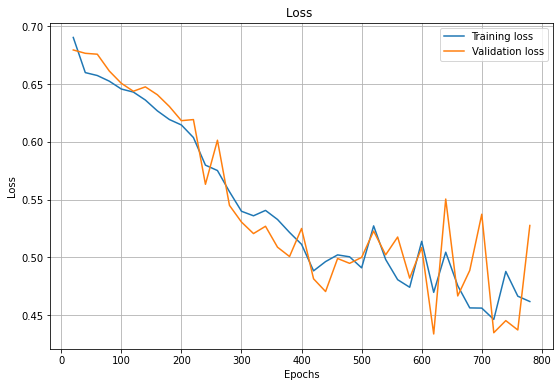

In [89]:
# let's exclude the first point to zoom in following steps
start_from = 1

plt.figure(figsize=(9, 6))
plt.title("Loss ")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history["epochs"][start_from:], history["train_loss_hist"][start_from:], label='Training loss')
# plt.plot(history["epochs"], history["train_loss_hist"], "ro")
plt.plot(history["epochs"][start_from:], history["val_loss_hist"][start_from:], label='Validation loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show();

#### Ok: from the training loss it seems that the network is learning... let's go to validation

Timings:
* GPU: 1min. 20'', 700 epochs
* CPU: 1 min. 22'', 700 epochs

L'utilizzation della GPU è bassa (13%), con cosi pochi dati l'impiego della GPU non fa la differenza.
Aumentando il batch size (64->256) ovviamente il tempo diminuisce ma le prestazioni peggiorano

Dal grafico si può osservare che da una certa epoch in poi (500?) il LR statico è troppo alto.
Un risultato migliore si può ottenere cambiando dinamicamente il LR... una prassi nei modelli "seri".
Vedremo in un capitolo successivo come si può fare.

### evaluate the model and compute accuracy

In [90]:
# è fondamentale mettere il modello in modalità eval
# per disabilitare il dropout che altrimenti produrrebbe un certo
# livello di casualità nell'inferenza

model_net.eval()

device = "cpu"

THR = 0.5

tot_correct = 0

for batch in val_dl:
    inputs, targets = batch
    
    inputs = inputs.to(device)
    targets = targets.to(device)
        
    outputs = model_net(inputs)
    
    class_outputs = torch.where(outputs >= THR, 1, 0)
    class_outputs = class_outputs.squeeze(1)
    outputs = outputs.squeeze(1)
    
    is_ok = torch.eq(class_outputs, targets)
    
    # ora è suffciente sommare True = 1
    tot_correct += is_ok.sum().item()

accuracy = round(tot_correct/len(val_set), 3)

print()
print("Summary:")
print(f"Accuracy on validation set is: {accuracy}")


Summary:
Accuracy on validation set is: 0.785


### conclusioni:
* over-sampling (fatto dalla classe AttritionDataset
* una definizione attenta degli iper-parametri (faticosa, n. neuroni, LR)

consentono di ottenere un'accuratezza tra il 73% e 80%... con TabNet vedremo che si riesce ad arrivare al 95% 